In [1]:
pip install pyarrow pandas_ta seaborn matplotlib scikit-learn==1.3.1 yfinance tensorflow.keras



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import pandas_ta as ta
from numpy import NaN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score , mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.linear_model import LogisticRegression
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import os
import yfinance as yf
warnings.filterwarnings("ignore")


2025-04-11 12:22:39.159236: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 12:22:39.454203: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-11 12:22:39.735180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744374160.780867  234838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744374161.077754  234838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 12:22:42.150007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import yfinance as yf
warnings.filterwarnings("ignore")

# df must have index as datetime64[ns], and 'signal' column
# freq can be 'daily', 'hourly', or 'minute'
def run_backtest(df, freq='h'):

  # check if df.index is datetime64[ns]
  if df.index.dtype != 'datetime64[ns]':
    raise ValueError("df.index must be in datetime64[ns]")

  # ------------------ Return Data Preparation ------------------
  if 'return_forward' in df.columns:
    df = df.drop(columns=['return_forward'])

  if freq == 'd':
    df = concat_return(df, freq)
    period_in_a_year = 365
  elif freq == 'h':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24
  elif freq == '5min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 12
  elif freq == '15min':
    df = concat_return(df, freq)
    period_in_a_year = 365 * 24 * 4
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  # ------------------ Data check ------------------
  if df['signal'].isnull().values.any():
    raise ValueError("DataFrame contains NA values")
  if 'signal' not in df.columns:
    raise ValueError("DataFrame is missing required column: 'signal'")

  # ------------------ Return & Sharpe ------------------
  # Daily returns
  df['strategy_return'] = df['signal'] * df['return_forward']

  # Geometric Annual Return
  num_periods = len(df)
  annual_return_geometric = (1 + df['strategy_return']).prod()**(period_in_a_year/num_periods) - 1
  
  # Arithmetic Annual Return for sharpe ratio calculation
  annual_return_arithmetic = df['strategy_return'].mean() * period_in_a_year

  # Sharpe Ratio
  daily_std = df['strategy_return'].std()
  annual_std = daily_std * np.sqrt(period_in_a_year)
  overall_sharpe = annual_return_arithmetic / annual_std

  print(f"Overall Annual Return: {round(annual_return_geometric*100, 2)}%")
  print("Overall Annual Sharpe Ratio:", round(overall_sharpe, 4))

  # ------------------ Maximum Drawdown ------------------
  df['cum_return'] = (1 + df['strategy_return']).cumprod()
  rolling_max = df['cum_return'].cummax()
  df['drawdown'] = (df['cum_return'] - rolling_max) / rolling_max
  max_drawdown = df['drawdown'].min()
  print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")

  # ------------------ Win/Loss Ratio ------------------
  # winning_trades = (df['strategy_return'] > 0).sum()
  # losing_trades = (df['strategy_return'] < 0).sum()
  # if losing_trades > 0:
  #   win_loss_ratio = winning_trades / losing_trades
  # else:
  #   win_loss_ratio = np.nan # no losing trades (advoid division by zero)
  # print("Win/Loss Ratio:", round(win_loss_ratio, 4))

  # ------------------ Alpha and Beta ------------------
  # Beta = Cov(strategy_return, acutal_return) / Var(actual_return)
  cov_matrix = np.cov(df['strategy_return'], df['return_forward'])
  beta = cov_matrix[0, 1] / cov_matrix[1, 1]

  # Alpha = mean(strategy_return) - Beta * mean(actual_return)
  alpha_daily = df['strategy_return'].mean() - beta * df['return_forward'].mean()

  # Annualize alpha
  alpha_annualized = (1 + alpha_daily) ** period_in_a_year - 1

  print("Alpha:", round(alpha_annualized, 4))
  print("Beta:", round(beta, 4))

  # ------------------- Yearly Metrics -------------------
  df['year'] = df.index.year

  yearly_data = df.groupby('year').apply(lambda subdf: pd.Series({
    'yearly_return': (1 + subdf['strategy_return']).prod()**(period_in_a_year/len(subdf)) - 1,
    'yearly_return_arithmetic': subdf['strategy_return'].mean() * period_in_a_year,
    'yearly_std': subdf['strategy_return'].std() * np.sqrt(period_in_a_year),
    'yearly_beta': np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1] /
                    np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1],
    'yearly_alpha': (
      subdf['strategy_return'].mean()
      - (
        np.cov(subdf['strategy_return'], subdf['return_forward'])[0,1]
        / np.cov(subdf['strategy_return'], subdf['return_forward'])[1,1]
      )
      * subdf['return_forward'].mean()
    ) * period_in_a_year
  })).reset_index()

  yearly_data['yearly_sharpe'] = yearly_data['yearly_return_arithmetic'] / yearly_data['yearly_std']
  yearly_data.drop(columns=['yearly_return_arithmetic'], inplace=True)
  print("\nYearly Metrics:")
  print(yearly_data)

  # ------------------------- Plots ----------------------
  df['cum_return_plot'] = (1 + df['strategy_return']).cumprod() - 1
  df['bh_cum_return_plot'] = (1 + df['return_forward']).cumprod() - 1

  # cumulative return plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['cum_return_plot'], label='Strategy Return')
  plt.plot(df.index, df['bh_cum_return_plot'], label='Buy and Hold')
  plt.title('Strategy Cumulative Return')
  plt.xlabel('Date')
  plt.ylabel('Cumulative Return')
  plt.legend()
  plt.show()

  # Signal weight plot
  plt.figure(figsize=(8,4))
  plt.plot(df.index, df['signal'], label='Signal')
  plt.title('Signal Weight Over Time')
  plt.xlabel('Date')
  plt.ylabel('Weight')
  plt.legend()
  plt.show()


def concat_return(df, freq='h'):
  if freq == 'd':
    file_path = "../../bitcoin_historical_price/btcusd_daily_price.parquet"
  elif freq == 'h':
    file_path = "../../bitcoin_historical_price/btcusd_hourly_price.parquet"
  elif freq == '5min':
    file_path = "../../bitcoin_historical_price/btcusd_5min_price.parquet"
  elif freq == '15min':
    file_path = "../../bitcoin_historical_price/btcusd_15min_price.parquet"
  else:
    raise ValueError("Invalid freq argument. Must be 'd', 'h', '5min', or '15min'")

  if os.path.exists(file_path):
    df_btc_return = pd.read_parquet(file_path)
  else:
    raise FileNotFoundError("Check file path: return data not found.")

  # merge return_forward to df
  merged_df = pd.merge(df, df_btc_return[['return_forward']], left_index=True, right_index=True, how='inner')

  # turn return_forward from decimal to float
  merged_df['return_forward'] = merged_df['return_forward'].apply(lambda x: float(x))
  return merged_df

In [4]:
price_indicator = pd.read_parquet("/workspaces/fyp/bitcoin_historical_price/btcusd_hourly_price_indicators.parquet")


In [5]:
reddit_results = pd.read_parquet("/workspaces/fyp/crypto_news/data/9.reddit_sentiment_processed.parquet.gzip")
reddit_results.rename(columns={"date": "date_hour"}, inplace=True)
reddit_results.set_index("date_hour", inplace=True)

reddit_results

,total_sentiment,average_sentiment
date_hour,,
2021-01-01 00:00:00,0.2966,0.015611
2021-01-01 01:00:00,1.6673,0.049038
2021-01-01 02:00:00,0.4588,0.021848
2021-01-01 03:00:00,-0.4329,-0.020614
2021-01-01 04:00:00,0.0000,0.000000
...,...,...
2024-12-31 19:00:00,0.0000,0.000000
2024-12-31 20:00:00,0.0000,0.000000
2024-12-31 21:00:00,0.0000,0.000000


In [6]:
btc_ner = pd.read_parquet("/workspaces/fyp/crypto_news/data/7a.News_by_hour_filled_return_ner.parquet")
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [7]:
target_col = "target"

start_date = pd.to_datetime("2024-01-01 10:00:00")
end_date = pd.to_datetime("2024-12-31 23:00:00")

# Training: 2021-01-01 to 2022-12-31
# price_indicator.set_index('Timestamp', inplace=True)
price_indicator.index.rename('date_hour', inplace=True)

# Filter rows starting from 2024-01-01 00:00
price_indicator_2024 = price_indicator.loc[start_date:end_date]

price_indicator_2024

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,rsi_14,atr_7,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,43.413306,227.310707,221.324993,221.660881,42681.044834,42415.6,42150.155166,42728.346865,42477.95,42227.553135
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,49.691448,224.266320,220.230351,220.915125,42655.006329,42402.2,42149.393671,42704.546857,42465.50,42226.453143
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,51.804047,205.656846,211.213897,214.871547,42645.307524,42398.1,42150.892476,42702.192013,42463.70,42225.207987
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,54.366986,189.277296,202.627190,208.972902,42667.255486,42426.9,42186.544514,42709.519104,42469.05,42228.580896
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,57.319131,181.380540,197.725248,205.402764,42705.425580,42464.6,42223.774420,42728.955773,42478.00,42227.044227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,49.600999,787.401340,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,42.325843,783.344006,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,46.155291,734.437720,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006


In [8]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
0,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
32090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
price_indicator_2024.index = pd.to_datetime(price_indicator_2024.index)
btc_ner.index = pd.to_datetime(btc_ner.index)
reddit_results.index = pd.to_datetime(reddit_results.index)

# Merge the DataFrames on the index (date_hour)
merged_df = pd.concat([price_indicator_2024, reddit_results], axis=1)

# Drop any rows with missing values (optional, if needed)
merged_df.dropna(inplace=True)

# Verify the merged DataFrame
# merged_df.drop("target",axis=1)
merged_df

,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,atr_14,atr_21,upper_band_10,middle_band_10,lower_band_10,upper_band_20,middle_band_20,lower_band_20,total_sentiment,average_sentiment
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,221.324993,221.660881,42681.044834,42415.6,42150.155166,42728.346865,42477.95,42227.553135,0.0000,0.000000
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,220.230351,220.915125,42655.006329,42402.2,42149.393671,42704.546857,42465.50,42226.453143,0.0000,0.000000
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,211.213897,214.871547,42645.307524,42398.1,42150.892476,42702.192013,42463.70,42225.207987,0.0000,0.000000
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,202.627190,208.972902,42667.255486,42426.9,42186.544514,42709.519104,42469.05,42228.580896,0.6800,0.170000
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,197.725248,205.402764,42705.425580,42464.6,42223.774420,42728.955773,42478.00,42227.044227,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,594.021005,490.327871,95801.067876,94516.7,93232.332124,95433.425204,94002.90,92572.374796,0.0000,0.000000
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,605.805219,503.121782,95876.395307,94461.6,93046.804693,95435.711991,93998.40,92561.088009,0.0000,0.000000
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,594.033418,500.163602,95898.271810,94421.0,92943.728190,95434.444994,94007.25,92580.055006,0.0000,0.000000


In [10]:
btc_ner

,date_hour,tanalysis_absa,economy_absa,regulation_absa,technology_absa,adoption_absa,entries_per_hour,Average Sentiment,Sentiment_6HR,Sentiment_12HR,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
1970-01-01 00:00:00.000000000,2021-01-01 10:00:00,0.766667,0.000000,0.0,0.0,0.300,3.0,0.213333,0.198889,0.216667,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000001,2021-01-01 11:00:00,1.000000,0.000000,0.0,0.0,0.000,2.0,0.200000,0.190000,0.202500,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000002,2021-01-01 12:00:00,0.700000,0.000000,0.0,0.0,0.225,4.0,0.185000,0.223333,0.210000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000003,2021-01-01 13:00:00,0.933333,0.233333,0.0,0.0,0.200,3.0,0.273333,0.210000,0.198333,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000000004,2021-01-01 14:00:00,0.900000,0.150000,0.0,0.0,0.000,2.0,0.210000,0.196667,0.140833,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000032087,2024-12-31 19:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032088,2024-12-31 20:00:00,0.000000,0.000000,0.0,0.0,0.000,6.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032089,2024-12-31 21:00:00,0.000000,0.000000,0.0,0.0,0.000,3.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1970-01-01 00:00:00.000032090,2024-12-31 22:00:00,0.000000,0.000000,0.0,0.0,0.000,4.0,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [11]:
btc_ner.set_index("date_hour", inplace=True)
merged_df = pd.merge(merged_df, btc_ner, on='date_hour', how='inner')
merged_df


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,0,0,0,0,1,0,0,0,0,0
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
merged_df.drop(columns=['target'], inplace=True)


In [13]:
inf_mask = merged_df.isin([np.inf, -np.inf])
very_large_mask = merged_df > np.finfo(np.float64).max

merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df[merged_df > np.finfo(np.float64).max] = np.nan

# Optionally, fill NaN values with a specific value or use interpolation
merged_df.fillna(method='ffill', inplace=True)  # Forward fill as an example

print(merged_df)


                        open     high      low    close     volume  \
date_hour                                                            
2024-01-01 10:00:00  42388.0  42396.0  42188.0  42234.0   8.907451   
2024-01-01 11:00:00  42216.0  42420.0  42214.0  42403.0   8.827538   
2024-01-01 12:00:00  42403.0  42497.0  42403.0  42465.0  47.764707   
2024-01-01 13:00:00  42494.0  42543.0  42452.0  42542.0  16.074770   
2024-01-01 14:00:00  42543.0  42676.0  42543.0  42635.0  22.040949   
...                      ...      ...      ...      ...        ...   
2024-12-31 19:00:00  93760.0  94158.0  93600.0  94008.0   7.863550   
2024-12-31 20:00:00  94025.0  94059.0  93300.0  93415.0   4.565475   
2024-12-31 21:00:00  93386.0  93777.0  93336.0  93682.0  28.484950   
2024-12-31 22:00:00  93703.0  93703.0  93227.0  93294.0  67.859345   
2024-12-31 23:00:00  93300.0  93582.0  93237.0  93381.0   4.859937   

                     return_forward    return            obv    sma_5  \
date_hour       

# Statistical Feature Selection

In [14]:
train_start_date = pd.to_datetime("2021-01-01 10:00:00")
train_end_date = pd.to_datetime("2023-12-31 23:00:00")

test_start_date = pd.to_datetime("2024-01-01 00:00:00")
test_end_date = pd.to_datetime("2024-12-31 23:00:00")


# Filter rows starting from 2024-01-01 00:00
price_indicator_train = merged_df.loc[train_start_date:train_end_date]
price_indicator_train_X = price_indicator_train.drop("return_forward",axis=1)
price_indicator_train_Y = price_indicator_train["return_forward"]

price_indicator_test = merged_df.loc[test_start_date:test_end_date]
price_indicator_test_X = price_indicator_test.drop("return_forward",axis=1)
price_indicator_test_Y = price_indicator_test["return_forward"]

price_indicator_test


,open,high,low,close,volume,return_forward,return,obv,sma_5,sma_10,...,Bitcoin ETFs,FTX collapse,Uptober,U.S. presidential election,Spot Bitcoin ETF approval,The Merge,US election,approval of spot Bitcoin ETFs,Bitcoin 2024 conference,U.S. election
date_hour,,,,,,,,,,,,,,,,,,,,,
2024-01-01 10:00:00,42388.0,42396.0,42188.0,42234.0,8.907451,0.004002,-0.003633,165696.695155,42426.2,42415.6,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 11:00:00,42216.0,42420.0,42214.0,42403.0,8.827538,0.001462,0.004002,165705.522693,42386.8,42402.2,...,0,0,0,0,1,0,0,0,0,0
2024-01-01 12:00:00,42403.0,42497.0,42403.0,42465.0,47.764707,0.001813,0.001462,165753.287401,42365.0,42398.1,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 13:00:00,42494.0,42543.0,42452.0,42542.0,16.074770,0.002186,0.001813,165769.362171,42406.4,42426.9,...,0,0,0,0,0,0,0,0,0,0
2024-01-01 14:00:00,42543.0,42676.0,42543.0,42635.0,22.040949,0.001220,0.002186,165791.403120,42455.8,42464.6,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,93760.0,94158.0,93600.0,94008.0,7.863550,-0.006308,0.002666,175364.391806,94342.2,94516.7,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 20:00:00,94025.0,94059.0,93300.0,93415.0,4.565475,0.002858,-0.006308,175359.826331,93968.2,94461.6,...,0,0,0,0,0,0,0,0,0,0
2024-12-31 21:00:00,93386.0,93777.0,93336.0,93682.0,28.484950,-0.004142,0.002858,175388.311280,93768.8,94421.0,...,0,0,0,0,0,0,0,0,0,0


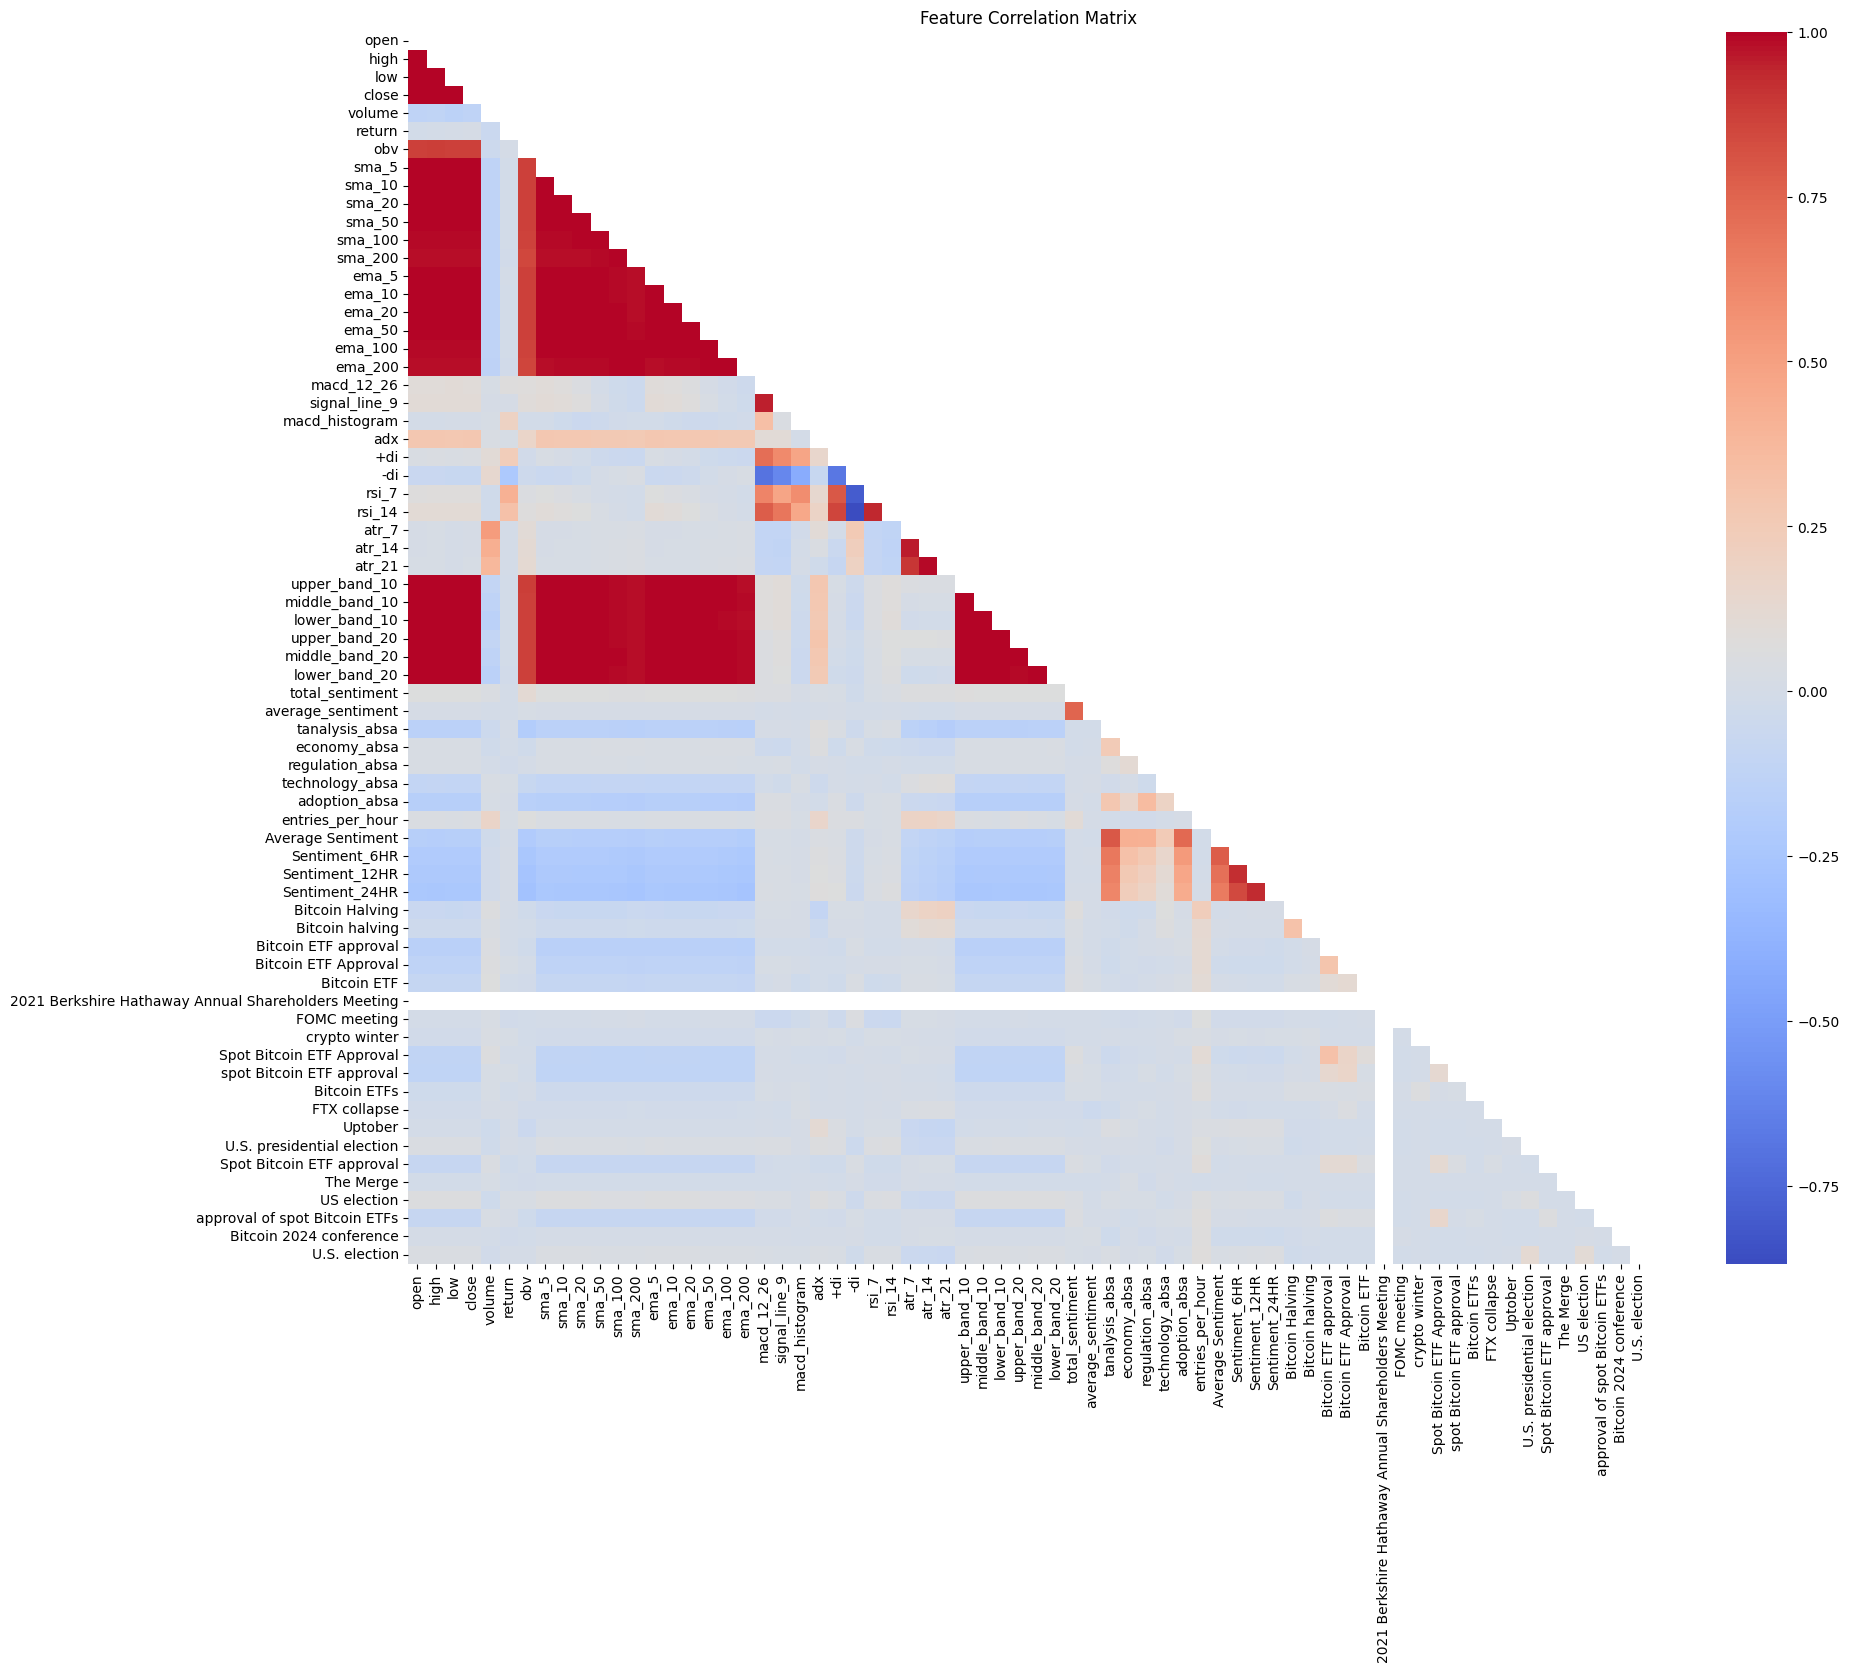

In [17]:
X = price_indicator_test_X
y = price_indicator_test_Y


plt.figure(figsize=(20, 16))
correlation_matrix = X.corr()
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()



In [18]:
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
def remove_correlated_features(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_drop, axis=1)

X_uncorrelated = remove_correlated_features(X)
print(f"Features reduced from {X.shape[1]} to {X_uncorrelated.shape[1]}")

# Feature importance using univariate selection
k_best_features = 15  # Select top 15 features
selector = SelectKBest(f_regression, k=k_best_features)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

print("Top features selected:", selected_features.tolist())
selected_features

Features reduced from 68 to 40
Top features selected: ['obv', 'sma_20', 'sma_200', 'ema_200', 'adx', '-di', 'middle_band_20', 'lower_band_20', 'total_sentiment', 'adoption_absa', 'Bitcoin halving', 'Bitcoin ETF', 'crypto winter', 'Spot Bitcoin ETF Approval', 'FTX collapse']


Index(['obv', 'sma_20', 'sma_200', 'ema_200', 'adx', '-di', 'middle_band_20',
       'lower_band_20', 'total_sentiment', 'adoption_absa', 'Bitcoin halving',
       'Bitcoin ETF', 'crypto winter', 'Spot Bitcoin ETF Approval',
       'FTX collapse'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[selected_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (8536, 12, 15)
y shape: (8536, 1)
Total sequences: 8536
Training sequences: 7682
Testing sequences: 854


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras.saving import register_keras_serializable
import tensorflow as tf

@register_keras_serializable(package="Custom", name="sharpe_loss")
def sharpe_loss(y_true, y_pred):
    # y_true: Actual asset returns (batch, time_steps, 1)
    # y_pred: Raw LSTM outputs (batch, time_steps, 1)
    
    # 1. Constrain weights to [-1, 1] (long/short) using tanh
    weights = tf.tanh(y_pred)  # Use sigmoid for [0, 1] (long-only)
    
    # 2. Compute strategy returns: weight * asset_return
    strategy_returns = weights * y_true  # (batch, time_steps, 1)
    
    # 3. Flatten returns across all batches and time steps
    returns_flattened = tf.reshape(strategy_returns, [-1])  # (batch * time_steps,)
    
    # 4. Sharpe ratio components
    mean_return = tf.reduce_mean(returns_flattened)
    std_return = tf.math.reduce_std(returns_flattened)
    sharpe_ratio = mean_return / (std_return + 1e-9)  # Avoid division by zero
    
    # 5. Minimize negative Sharpe to maximize it
    return -sharpe_ratio


# Define model architecture
model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss=sharpe_loss)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions

2025-04-11 12:26:42.334378: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: -7.2664e-04 - val_loss: nan
Epoch 2/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 3/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 4/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 5/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 6/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 7/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: nan - val_loss: nan
Epoch 8/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 9/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: nan - val_loss: nan
Epoch 10/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: nan - val_loss: nan
Epoch 11/100
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: nan - val_loss: nan
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan
Test Loss: nan
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10m

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      

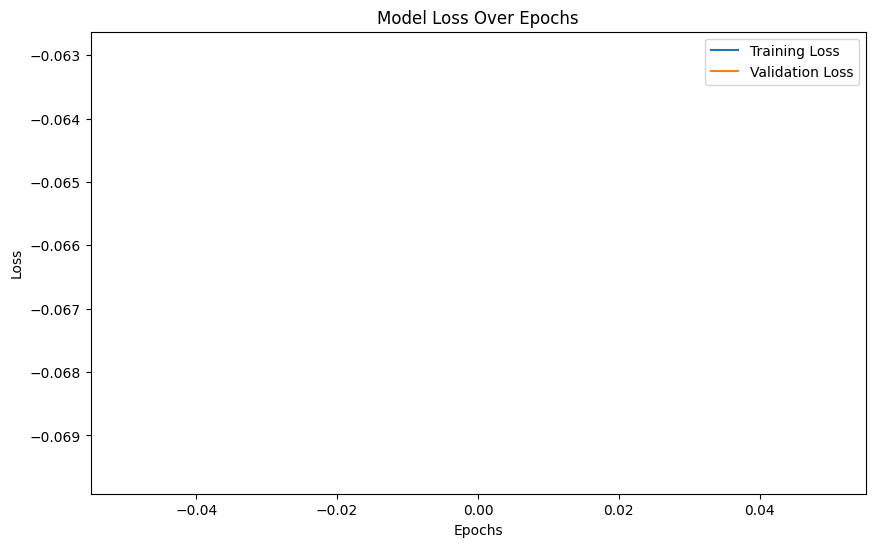

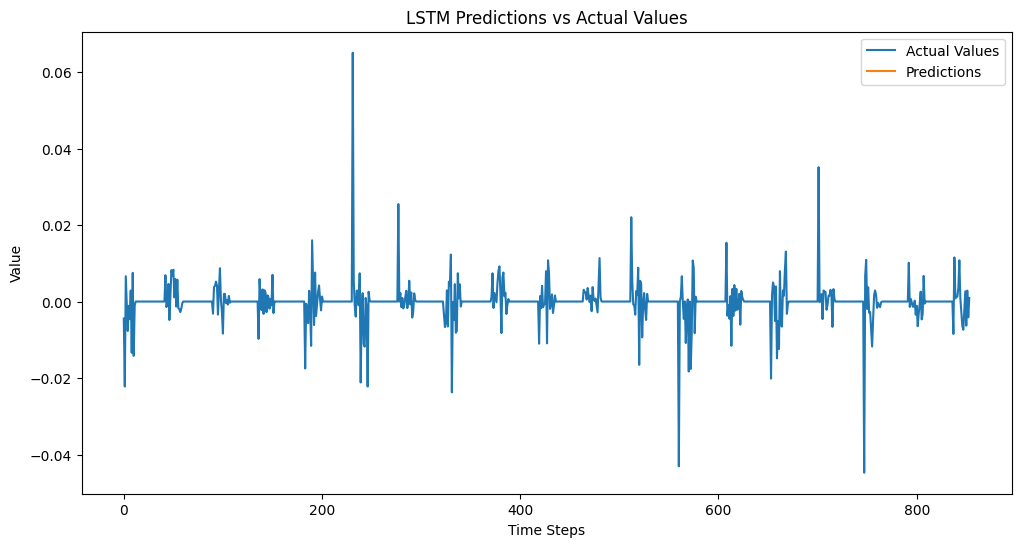

In [21]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [22]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)


In [23]:
model.save('stat_features_selection_lstm_model_S0.keras')  # HDF5 format


In [24]:
y_test

array([[0.32954894],
       [0.18437009],
       [0.42011124],
       [0.36073643],
       [0.30295387],
       [0.35691313],
       [0.32844425],
       [0.389597  ],
       [0.25654981],
       [0.42738516],
       [0.24991248],
       [0.35784262],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.36601665],
       [0.42223639],
       [0.35422034],
       [0.36199136],
       [0.40366289],
       [0.32653853],
       [0.376

In [25]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('stat_features_selection_lstm_model_S0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)
results_df


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


,Actual,Predicted
2024-11-25 13:00:00,-0.004460,NaN
2024-11-25 14:00:00,-0.022214,NaN
2024-11-25 15:00:00,0.006615,NaN
2024-11-25 16:00:00,-0.000646,NaN
2024-11-25 17:00:00,-0.007712,NaN
...,...,...
2024-12-31 19:00:00,0.002666,NaN
2024-12-31 20:00:00,-0.006308,NaN
2024-12-31 21:00:00,0.002858,NaN
2024-12-31 22:00:00,-0.004142,NaN


In [26]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
previous_prediction = stat_signal_result_df['Predicted'].shift(1)

# Apply the logic for determining the signal
stat_signal_result_df['signal'] = stat_signal_result_df.apply(
    lambda row: 1 if row['Predicted'] > previous_prediction[row.name] * 1.025 else
    (-1 if row['Predicted'] < previous_prediction[row.name] * 0.975 else 0),
    axis=1
)
stat_signal_result_df

,Predicted,signal
2024-11-25 13:00:00,NaN,0
2024-11-25 14:00:00,NaN,0
2024-11-25 15:00:00,NaN,0
2024-11-25 16:00:00,NaN,0
2024-11-25 17:00:00,NaN,0
...,...,...
2024-12-31 19:00:00,NaN,0
2024-12-31 20:00:00,NaN,0
2024-12-31 21:00:00,NaN,0
2024-12-31 22:00:00,NaN,0


In [27]:
stat_signal_result_df = results_df.drop("Actual",axis=1)
previous_prediction = stat_signal_result_df['Predicted'].shift(1)

# Apply the logic for determining the signal
stat_signal_result_df['signal'] = stat_signal_result_df.apply(
    lambda row: 1 if row['Predicted'] > previous_prediction[row.name] * 1.025 else
    (-1 if row['Predicted'] < previous_prediction[row.name] * 0.975 else 0),
    axis=1
)
stat_signal_result_df

,Predicted,signal
2024-11-25 13:00:00,NaN,0
2024-11-25 14:00:00,NaN,0
2024-11-25 15:00:00,NaN,0
2024-11-25 16:00:00,NaN,0
2024-11-25 17:00:00,NaN,0
...,...,...
2024-12-31 19:00:00,NaN,0
2024-12-31 20:00:00,NaN,0
2024-12-31 21:00:00,NaN,0
2024-12-31 22:00:00,NaN,0


Overall Annual Return: 0.0%
Overall Annual Sharpe Ratio: nan
Maximum Drawdown: 0.0 %
Alpha: 0.0
Beta: 0.0

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024            0.0         0.0          0.0           0.0            NaN


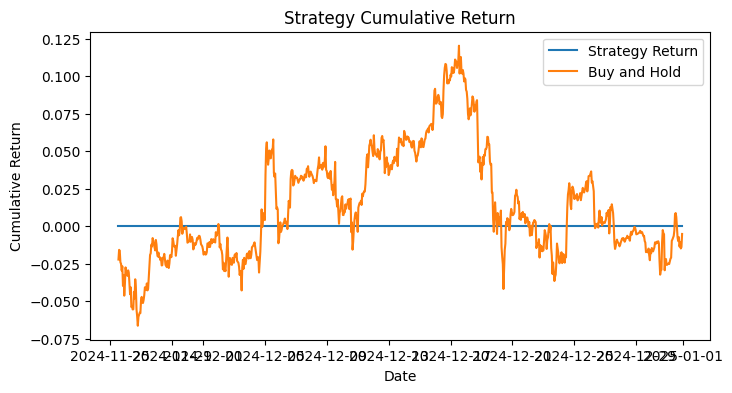

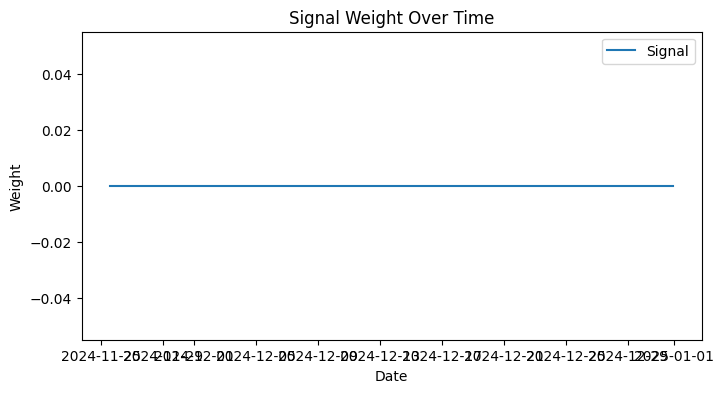

In [28]:
run_backtest(stat_signal_result_df)

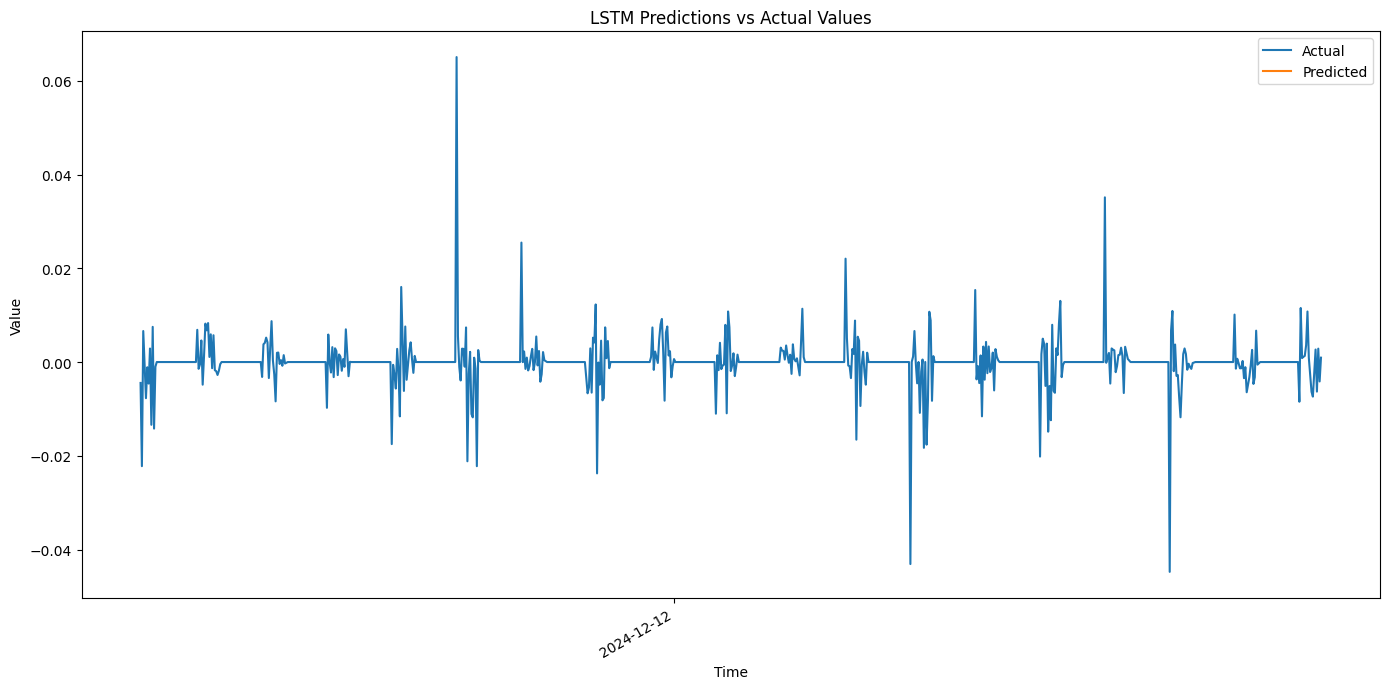

In [29]:
# Now you can plot with proper time indexes
plt.figure(figsize=(14, 7))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted')

# Format x-axis if using DatetimeIndex
if isinstance(results_df.index, pd.DatetimeIndex):
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
    plt.gcf().autofmt_xdate()

plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# Select features that are most important for predicting time series patterns
sfs = SequentialFeatureSelector(
    LinearRegression(), 
    n_features_to_select=15,
    direction='forward',
    cv=5,
)
X_selected = sfs.fit_transform(X, y)
selected_feature_names = X.columns[sfs.get_support()]

# Use these features for LSTM model
lstm_features = selected_feature_names


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X_df = merged_df[lstm_features].values
y_df = merged_df['return'].values  # Replace with your target column name
original_indexes = merged_df.index.tolist()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_df)

# If your target needs scaling too (for regression problems)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y_df.reshape(-1, 1))

# Define sequence length (time steps to look back)
sequence_length = 12  # Adjust based on your specific problem

# Create sequences for LSTM
X_sequences = []
y_sequences = []
sequence_indexes = []

for i in range(len(X_scaled) - sequence_length):
    X_sequences.append(X_scaled[i:i+sequence_length])
    y_sequences.append(y_scaled[i+sequence_length])
    sequence_indexes.append(original_indexes[i+sequence_length])

# Convert to numpy arrays
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Check the resulting shapes
print(f"X shape: {X_sequences.shape}")  # Should be (samples, sequence_length, num_features)
print(f"y shape: {y_sequences.shape}")  # Should be (samples, 1) or (samples,)

# Split into training and testing sets

X_train, X_test, y_train, y_test ,train_idx, test_idx = train_test_split(
    X_sequences, y_sequences, sequence_indexes, test_size=0.1, shuffle=False
)

print(f"Total sequences: {len(sequence_indexes)}")
print(f"Training sequences: {len(train_idx)}")
print(f"Testing sequences: {len(test_idx)}")


X shape: (31898, 12, 15)
y shape: (31898, 1)
Total sequences: 31898
Training sequences: 28708
Testing sequences: 3190


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras.saving import register_keras_serializable

@register_keras_serializable(package="Custom", name="sharpe_loss")
def sharpe_loss(y_true, y_pred):
    # y_true: Actual asset returns (batch, time_steps, 1)
    # y_pred: Raw LSTM outputs (batch, time_steps, 1)
    
    # 1. Constrain weights to [-1, 1] (long/short) using tanh
    weights = tf.tanh(y_pred)  # Use sigmoid for [0, 1] (long-only)
    
    # 2. Compute strategy returns: weight * asset_return
    strategy_returns = weights * y_true  # (batch, time_steps, 1)
    
    # 3. Flatten returns across all batches and time steps
    returns_flattened = tf.reshape(strategy_returns, [-1])  # (batch * time_steps,)
    
    # 4. Sharpe ratio components
    mean_return = tf.reduce_mean(returns_flattened)
    std_return = tf.math.reduce_std(returns_flattened)
    sharpe_ratio = mean_return / (std_return + 1e-9)  # Avoid division by zero
    
    # 5. Minimize negative Sharpe to maximize it
    return -sharpe_ratio


model = Sequential()
model.add(LSTM(64, activation='relu', return_sequences=True, 
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer - 1 neuron for regression

# Compile model
model.compile(optimizer='adam', loss=sharpe_loss)

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Inverse transform predictions to original scale (if you scaled y)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)
predictions 

Epoch 1/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: -1.5134e-04 - val_loss: -2.8866e-04
Epoch 2/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: -2.0097e-04 - val_loss: -2.8866e-04
Epoch 3/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: -1.9616e-04 - val_loss: -2.8866e-04
Epoch 4/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: -1.9546e-04 - val_loss: -2.8866e-04
Epoch 5/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: -1.9950e-04 - val_loss: -2.8866e-04
Epoch 6/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: -1.9737e-04 - val_loss: -2.8866e-04
Epoch 7/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: -1.9697e-04 - val_loss: -2.8866e-04
Epoch 8/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: -1.9636e-04 - val_loss: -2.8866e-04
Epoch 9/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: -1.9584e-04 - val_loss: -2.8866e-04
Epoch 10/100
718/718 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: -1.9588e-04 - val_loss: -2.8866e-04
Epoch 11/100
718/718 ━━━━━━━━

array([[ 8.951238],
       [ 9.019482],
       [ 9.01753 ],
       ...,
       [12.088027],
       [11.93595 ],
       [11.828256]], dtype=float32)

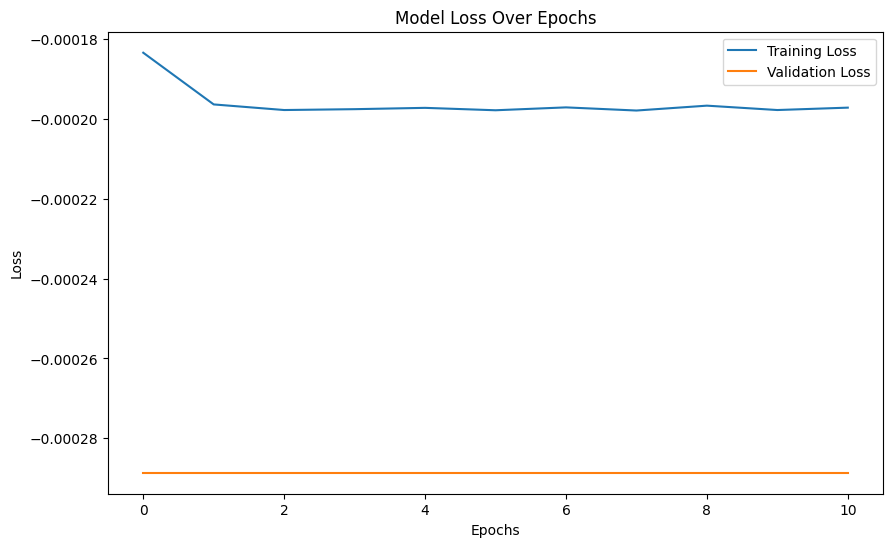

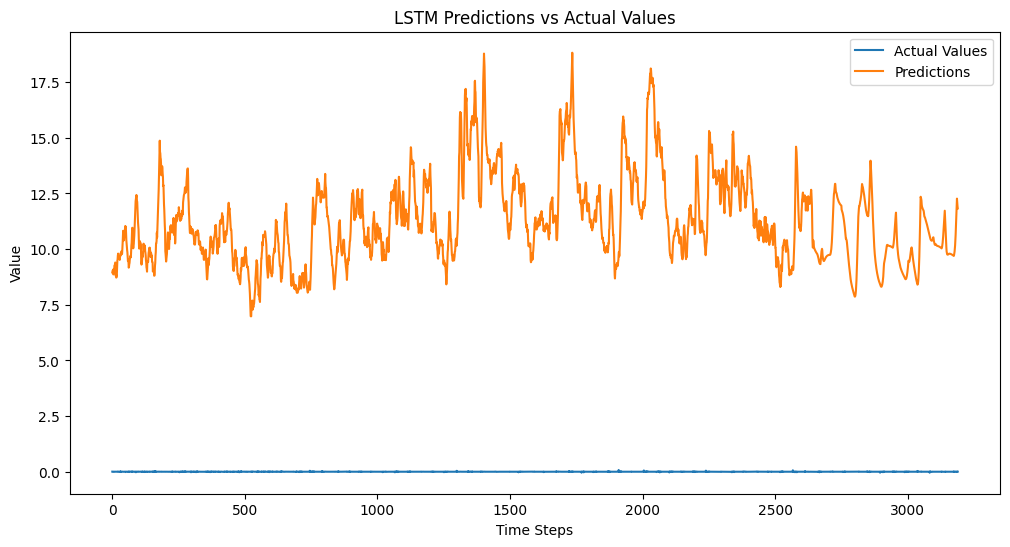

In [ ]:
import matplotlib.pyplot as plt

# Plot loss history (for Keras model)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Values')
plt.plot(predictions, label='Predictions')
plt.title('LSTM Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
import pickle

# Save feature scaler
with open('feature_scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save target scaler (if used)
with open('target_scaler.pkl', 'wb') as file:
    pickle.dump(y_scaler, file)
    
# Save feature list
with open('selected_features.pkl', 'wb') as file:
    pickle.dump(selected_features, file)

model.save('sequential_selection_lstm_model_S0.keras')  # HDF5 format


In [ ]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model = load_model('sequential_selection_lstm_model_S0.keras')  # Your saved model
predictions = model.predict(X_test)
predictions = y_scaler.inverse_transform(predictions)
y_test_actual = y_scaler.inverse_transform(y_test)

# Create DataFrame with predictions and actual values with proper indexes
results_df = pd.DataFrame({
    'Actual': y_test_actual.flatten(),
    'Predicted': predictions.flatten()
}, index=test_idx)

stat_signal_result_df = results_df.drop("Actual",axis=1)
previous_prediction = stat_signal_result_df['Predicted'].shift(1)

# Apply the logic for determining the signal
stat_signal_result_df['signal'] = stat_signal_result_df.apply(
    lambda row: 1 if row['Predicted'] > previous_prediction[row.name] * 1.025 else
    (-1 if row['Predicted'] < previous_prediction[row.name] * 0.975 else 0),
    axis=1
)
stat_signal_result_df

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,Predicted,signal
2024-08-16 22:00:00,8.951238,0
2024-08-16 23:00:00,9.019482,0
2024-08-17 00:00:00,9.017530,0
2024-08-17 01:00:00,9.080118,0
2024-08-17 02:00:00,8.863356,0
...,...,...
2024-12-31 19:00:00,11.951593,1
2024-12-31 20:00:00,12.267847,1
2024-12-31 21:00:00,12.088027,0
2024-12-31 22:00:00,11.935950,0


In [ ]:
results_df

,Actual,Predicted
2024-08-16 22:00:00,0.004154,8.951238
2024-08-16 23:00:00,0.003817,9.019482
2024-08-17 00:00:00,-0.006399,9.017530
2024-08-17 01:00:00,-0.004771,9.080118
2024-08-17 02:00:00,-0.000576,8.863356
...,...,...
2024-12-31 19:00:00,0.002666,11.951593
2024-12-31 20:00:00,-0.006308,12.267847
2024-12-31 21:00:00,0.002858,12.088027
2024-12-31 22:00:00,-0.004142,11.935950


Overall Annual Return: 42.59%
Overall Annual Sharpe Ratio: 1.621


Maximum Drawdown: -10.64 %
Alpha: 0.433
Beta: 0.0161

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.425877    0.236036     0.016086      0.359798       1.621036


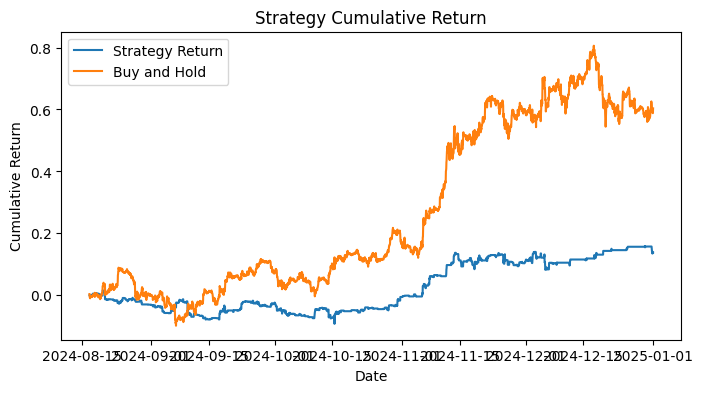

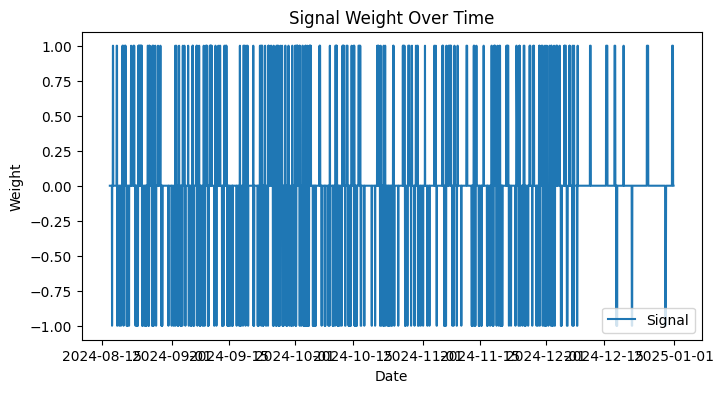

In [ ]:
run_backtest(stat_signal_result_df)